In [1]:
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr 
from scipy import interpolate
import matplotlib.pyplot as plt 

import thermal.plotting as plotting
from thermal.plotting import enthalpy_pcolormesh
from thermal.derived_fields import calc_mean_enthalpy


plt.rcParams['text.usetex']    = True

In [2]:
key = 'crmpt12'

Let's find of a list of the simulations which reached some time threshold. 

This is mainly to filter out runs that failed (mostly likely to CFL condition problems). 

In [3]:
file_list = []

i = 0 
j = 0 

for file in glob.glob(f'/Volumes/thermal_ssd/crmpt12/thinned/*.zarr'): 
    i += 1
    with xr.open_zarr(file) as src: 
        if src.t[-1] >= 2000: 
            file_list.append(file) 
            j += 1

In [4]:
rate = (j / i) * 100

print(f'{rate:.0f} % success rate')

85 % success rate


In [5]:
%%time

SS_2kya = xr.open_mfdataset(file_list, engine='zarr', parallel='true')

# actually make the relative volume relatives
SS_2kya['relative_volume'] /= SS_2kya['relative_volume'].isel(t=0)

CPU times: user 18.6 s, sys: 1.22 s, total: 19.8 s
Wall time: 21.1 s


In [49]:
%%time 

#
subset = SS_2kya[['enthalpy_h', 'height', 'X']].isel(t=slice(-10,None)).compute()
# use the last year's worth of data to compute the weighted mean enthalpy in kJ / kg
mean_enthalpy = calc_mean_enthalpy(subset) / 1e3
# calculte annual average and mask the zero's as nans
mean_enthalpy = mean_enthalpy.mean('t').where(lambda x: x!=0, np.nan)

CPU times: user 59.5 s, sys: 36.7 s, total: 1min 36s
Wall time: 42.6 s


In [52]:
mean_enthalpy.max()

<xarray.DataArray ()>
array(134.35621711)

In [38]:
def interpolate_na_2D(ds): 
    
    # collapse along a single dimension
    stacked = ds.stack(interper = ('offset', 'T_ma'))
    # drop the values which are nan
    thinned = stacked.where(~stacked.isnull(), drop=True)
    
    # create the radial basis function interpolator 
    def create_interpolater(X_obs, Y_obs, Z_obs):
        data_coords = np.vstack([X_obs, Y_obs]).T
        return interpolate.RBFInterpolator(data_coords, Z_obs)
    
    # create an instance of the the interpolator 
    interpolater = create_interpolater(thinned.offset, 
                                       thinned.T_ma,
                                       thinned)
    
    def evaluate(X,Y): 
        Z = interpolater(np.vstack([X, Y]).T)
        return Z
    
    return xr.apply_ufunc(evaluate,
                   stacked.offset,
                   stacked.T_ma,
                   input_core_dims=[["interper"], ["interper"]],
                   output_core_dims=[["interper"]],
                   vectorize=True,
                   dask="parallelized",
                   output_dtypes=[stacked.dtype]).unstack()



In [39]:
def interpolate_grids(src, vars=['relative_volume', 'percent_temperate'], dims=['T_ma', 'offset']): 
    # make copy, new reference in memory 
    ds = src[vars].persist().copy()
    
    def fill_nans_1D(src, dim, method='cubic'): 
        
        # allow for extrapolation at boundaries
        kwargs = {"fill_value" : "extrapolate"}
        # interpolate over nans along a single dimension
        src = src.chunk({dim : -1}).interpolate_na(dim=dim, method=method, **kwargs)
        
        return src
    
    
    for var in vars: 
        ds[var] = interpolate_na_2D(ds[var])
    
    return ds

In [60]:
# start by interpolating nan's in the V' and % temp fields
interpolated = interpolate_grids(SS_2kya.isel(t=-1)).expand_dims('t')

interpolated['mean_enthalpy'] = interpolate_na_2D(mean_enthalpy).expand_dims('t')


In [54]:
# Modeled grid of parameter vals
T_mgrid, B_mgrid = np.meshgrid(SS_2kya.T_ma, SS_2kya.offset)

# Dense grid of parameter vals for visulaization
T_dgrid, B_dgrid = np.meshgrid(np.linspace(T_mgrid.min(),T_mgrid.max(),50), 
                               np.linspace(B_mgrid.min(),B_mgrid.max(),50))



In [55]:
# get the boolean mask of nan values
mask  = np.isnan(SS_2kya.relative_volume.sel(t=2000, method='nearest').compute().values)
mask2 = np.isnan(SS_2kya.percent_temperate.sel(t=2000, method='nearest').compute().values)

assert np.alltrue(mask == mask2)

In [56]:
print(B_mgrid[:,:].shape)
print(T_mgrid[:,:].shape)
print(SS_2kya['percent_temperate'].shape)

(26, 11)
(26, 11)
(26, 11, 3000)


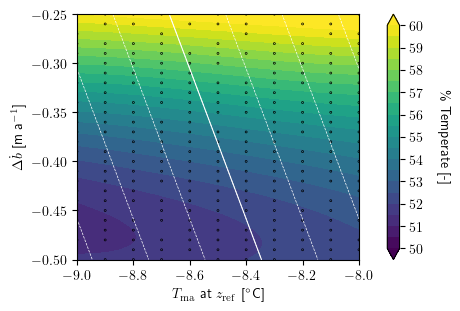

In [128]:

# greate spline fit parameters
tck  = interpolate.bisplrep(B_mgrid, T_mgrid, interpolated['percent_temperate'].isel(t=-1).values)

znew = interpolate.bisplev(B_dgrid[:,0], T_dgrid[0,:], tck)


fig, ax = plt.subplots(1,1, figsize=(4.5,3), 
                       constrained_layout=True)

if key == 'crmpt12': 
    levels = np.linspace(50, 60, 21)
    
elif key == 'glc1-a': 
    levels = np.linspace(10, 45, 36)
    
    
im = ax.contourf(T_dgrid, B_dgrid, znew, levels=levels, extend='both')
# im = ax.scatter(T_mgrid, B_mgrid, c=SS_2kya.percent_temperate,  )
s  = ax.scatter(T_mgrid[~mask], B_mgrid[~mask], s=2.0, edgecolors='k', marker='o', linewidths=0.5, facecolors='none')
# n  = ax.scatter(T_mgrid[mask], B_mgrid[mask], s=5.0, c='k', marker='x', linewidths=0.5)

ax.contour(T_mgrid, B_mgrid, T_mgrid - (1/-0.76428249) * B_mgrid, levels=7, linewidths=0.5, colors='white')
plt.plot(-9 + (1/-0.76428249) * np.linspace(B_mgrid.min(),B_mgrid.max(),50), 
         np.linspace(B_mgrid.min(),B_mgrid.max(),50), color='white', ls="-", lw=0.75)


# ax.set_title(f'{key}')
ax.set_xlabel('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]') 
ax.set_ylabel('$\Delta \dot{b}$ [m a$^{-1}$]')

if key == 'glc1-a': 
    ax.set_xlim(-8.0, None)

cbar = fig.colorbar(im, ticks=np.linspace(50, 60, 11), drawedges=False)
# annotate the colorbar axes
cbar.set_label('\% Temperate [-]', rotation=270, labelpad=20)

fig.savefig(f'./figs/{key}/{key}_PercTemp_GS_new.png',  dpi=600, bbox_inches='tight', facecolor='w')

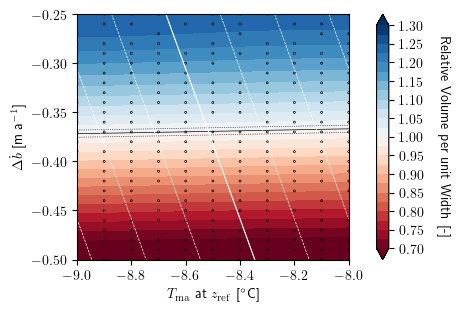

In [126]:
if key == 'crmpt12': 
    tck  = interpolate.bisplrep(B_mgrid[:-1,:], T_mgrid[:-1,:], interpolated['relative_volume'].isel(t=-1).values[:-1,:])
else: 
    tck  = interpolate.bisplrep(B_mgrid, T_mgrid, interpolated['relative_volume'].isel(t=-1).values)
    
    
znew = interpolate.bisplev(B_dgrid[:,0], T_dgrid[0,:], tck)

fig, ax = plt.subplots(1,1, figsize=(4.5,3), 
                       constrained_layout=True)


if key == 'crmpt12': 
    levels = np.linspace(40, 60, 21)
    
elif key == 'glc1-a': 
    levels = np.linspace(0, 45, 46)
    
im = ax.contourf(T_dgrid, B_dgrid, znew, levels=np.linspace(0.7,1.3,25), cmap='RdBu', extend='both')
# im = ax.scatter(T_mgrid, B_mgrid, c=SS_2kya.relative_volume,  cmap='RdBu',)

s  = ax.scatter(T_mgrid[~mask], B_mgrid[~mask], s=2.0, edgecolors='k', marker='o', linewidths=0.5, facecolors='none')
# n  = ax.scatter(T_mgrid[mask], B_mgrid[mask], s=5.0, c='k', marker='x', linewidths=0.5)


ax.contour(T_dgrid, B_dgrid, znew, levels=[0.99, 1.0, 1.01], linestyles=[':', '-', ':'], colors='k', linewidths=0.5)
# ax.contourf(T_dgrid, B_dgrid, znew, levels=[0.99, 1.01], cmap='binary', alpha=0.25)

ax.contour(T_mgrid, B_mgrid, T_mgrid - (1/-0.76428249) * B_mgrid, levels=7, linewidths=0.5, colors='white')

plt.plot(-9 + (1/-0.76428249) * np.linspace(B_mgrid.min(),B_mgrid.max(),50), 
         np.linspace(B_mgrid.min(),B_mgrid.max(),50), color='white', ls="-", lw=0.75)

# ax.set_title(f'{key}')
ax.set_xlabel('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]')
ax.set_ylabel('$\Delta \dot{b}$ [m a$^{-1}$]')


cbar = fig.colorbar(im, ticks=np.linspace(0.7,1.3, 13), drawedges=False, extend='both')
# annotate the colorbar axes
cbar.set_label('Relative Volume per unit Width [-]', rotation=270, labelpad=20)



if key == 'glc1-a': 
    ax.set_xlim(-8.0, None)
    

fig.savefig(f'./figs/{key}/{key}_RelVol_GS_new.png', 
            dpi=600, bbox_inches='tight', 
            facecolor='w')

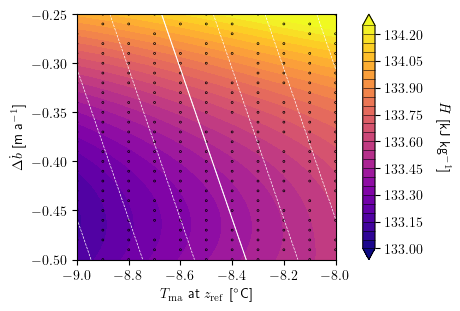

In [129]:
# # greate spline fit parameters
tck  = interpolate.bisplrep(B_mgrid, T_mgrid, interpolated['mean_enthalpy'].isel(t=-1).values)

znew = interpolate.bisplev(B_dgrid[:,0], T_dgrid[0,:], tck)


fig, ax = plt.subplots(1,1, figsize=(4.5,3), 
                       constrained_layout=True)

levels = np.linspace(133.0, 134.25, 26)
    

im = ax.contourf(T_dgrid, B_dgrid, znew, levels=levels, extend='both', cmap='plasma')
# im = ax.scatter(T_mgrid, B_mgrid, c=SS_2kya.per6cent_temperate,  )
s  = ax.scatter(T_mgrid[~mask], B_mgrid[~mask], s=2.0, edgecolors='k', marker='o', linewidths=0.5, facecolors='none')
# n  = ax.scatter(T_mgrid[mask], B_mgrid[mask], s=5.0, c='k', marker='x', linewidths=0.5)

ax.contour(T_mgrid, B_mgrid, T_mgrid - (1/-0.76428249) * B_mgrid, levels=7, linewidths=0.5, colors='white')
plt.plot(-9 + (1/-0.76428249) * np.linspace(B_mgrid.min(),B_mgrid.max(),50), 
         np.linspace(B_mgrid.min(),B_mgrid.max(),50), color='white', ls="-", lw=0.75)


# ax.set_title(f'{key}')
ax.set_xlabel('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]')
ax.set_ylabel('$\Delta \dot{b}$ [m a$^{-1}$]')

if key == 'glc1-a': 
    ax.set_xlim(-8.0, None)

cbar = fig.colorbar(im, drawedges=True)
# annotate the colorbar axes
cbar.set_label(r'$\bar{H}$ [kJ kg$^{-1}$]', rotation=270, labelpad=20)
#
fig.savefig(f'./figs/{key}/{key}_MeanEnth_GS_new.png',  dpi=600, bbox_inches='tight', facecolor='w')

In [82]:
if key == 'crmpt12': 
    subset = SS_2kya.isel(t=[0,-1], T_ma=[0, 5, 10], offset=[2 ,12,-4])
    # squeeze the time dimension, since 
    subset['X'] = subset.X.isel(t=0)
    
elif key == 'glc1-a': 
    subset = SS_2kya.isel(T_ma=slice(10,None,2), offset=slice(0,None,4))
    

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(7, 4), 
                         sharex=True, sharey=True, 
                         constrained_layout=True)

for i in range(3): 
    
    k = 2-i
    print(2-i)
#     δ_b = float(subset.offset[i])
#     axes[i,  0].set_ylabel(f'$\Delta \dot{{b}}={δ_b}$')

#     if i > 0: 
#         j = i-1 
#         T_ma = float(subset.T_ma[j])
#         axes[-1, j].set_xlabel(f'$T_{{ma}} ={T_ma}$')
    
    for j in range(3):
        
        if j == 0: 
            δ_b = float(subset.offset[k])
            axes[i,  j].set_ylabel(f'$\Delta \dot{{b}}={δ_b}$')

        if i == 0: 
            # j = i-1 
            T_ma = float(subset.T_ma[j])
            axes[-1, j].set_xlabel(f'$T_{{\\rm ma}} ={T_ma}$')
            
            
        if pd.isna(subset.isel(T_ma=j, offset=k).enthalpy_h.mean()): 
            continue 
        
        im = enthalpy_pcolormesh(subset.isel(T_ma=j, offset=k), -1, axes=axes[i,j], W_max=1.0)
        
        # plot the inital condition
        axes[i,j].plot(subset.isel(T_ma=j, offset=k).X[0,::-1]/1e3, 
                       subset.isel(T_ma=j, offset=k).Z.isel(t=0, coord_2=-1),
                lw=1.0, c='k', ls=":", zorder=3, label='$z_{\\rm s}(t=0)$')    
        
        V = float(subset['relative_volume'].isel(t=-1, T_ma=j, offset=k))
        P = float(subset['percent_temperate'].isel(t=-1, T_ma=j, offset=k))
        
        axes[i,j].text(0.175, 0.1, f"$V'$ = {V:3.2f}", 
                           transform=axes[i,j].transAxes,
                           ha='center', va='center', fontsize='small')
        
        
        axes[i,j].text(0.175, 0.2, f"$\%T$ = {P:3.1f}", 
                           transform=axes[i,j].transAxes,
                           ha='center', va='center', fontsize='small')
        
        axes[i,j].get_xaxis().set_ticks([])
        axes[i,j].get_yaxis().set_ticks([])
        
        axes[i,j].spines.right.set_visible(False)
        axes[i,j].spines.top.set_visible(False)
        
        # for spine in axes[i, j].spines.values():
        #     spine.set_visible(False)

cbar = fig.colorbar(im, ax=axes) 
cbar.set_ticks(np.concatenate((np.linspace(-8, 0, 9),
               np.linspace(0.2, 1.0, 5))))
cbar.set_label('Water Content [$\%$] / Homologous Temperature [$^\circ$C]', 
               rotation=270, labelpad=10)

# axes[0,0].set_xlim(None, 6e3)
# axes[0,0].set_ylim(1.75e3, None)

In [ ]:
fig.savefig(f'./figs/{key}/{key}_distributed_GS_new.png', 
            dpi=600, bbox_inches='tight', 
            facecolor='w')

In [ ]:
sub = SS_2kya['relative_volume'].compute()

In [ ]:
import matplotlib.cm as cm

def make_colorbar(array, cmap='plasma'):
    #---------------------------------------------------------------------------
    # For Seting up the colorbar:
    #    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
    #---------------------------------------------------------------------------
    vmin  = array.min()
    vmax  = array.max()
    vsize = array.size
    vdv   = array[1] - array[0]
    
    cmap = getattr(cm, cmap)
    norm = cm.colors.Normalize(vmin=vmin, vmax=vmax)

    s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(np.linspace(vmin, vmax, vsize))

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = vdv / 2.0
    bounds   = np.linspace(vmin  - halfdist,
                           vmax  + halfdist,
                           vsize + 1)

    return cmap, norm, s_map, bounds

In [ ]:
cmap, norm, s_map, bounds = make_colorbar(Z_s.offset)

fig, ax = plt.subplots(figsize=(9, 5))

for δb in sub.offset: 
    
    color = cmap(norm(δb))
    
    sub.sel(T_ma=-8.5, offset=δb).plot(x='t', ax=ax, c=color)

ax.axhline(0.99, ls=':', c='k', lw=1.0)
ax.axhline(1.01, ls=':', c='k', lw=1.0)
ax.axhline(1.00, ls='-', c='k', lw=1.0)


cbar = fig.colorbar(s_map,
                spacing='proportional',
                ticks=np.linspace(sub.offset.min(),
                                  sub.offset.max(),
                                  sub.offset.size),
                ax=ax,
                boundaries=bounds,
                drawedges=True,
                format='%2.{}f'.format(2))

ax.set_title(r'Slice at $T_{\rm ma}$=-8.5 [$^\circ$C]')
ax.set_ylabel('Relative Volume per Unit Width [-]')
ax.set_xlabel('Time [a]')
# annotate the colorbar axes
cbar.set_label('$\Delta \dot b$ [m a$^{-1}$]', rotation=270, labelpad=20)

ax.set_ylim(0.625, 1.30)


fig.savefig(f'./figs/{key}/{key}_Vprime_wrt_offset_at_Tma_-8.5.png', 
            dpi=600, bbox_inches='tight', 
            facecolor='w')

In [ ]:
cmap, norm, s_map, bounds = make_colorbar(Z_s.T_ma)

fig, ax = plt.subplots(figsize=(9, 5))

for δT in sub.T_ma: 
    
    color = cmap(norm(δT))
    
    sub.sel(T_ma=δT, offset=-0.37).plot(x='t', ax=ax, c=color)

ax.axhline(0.99, ls=':', c='k', lw=1.0)
ax.axhline(1.01, ls=':', c='k', lw=1.0)
ax.axhline(1.00, ls='-', c='k', lw=1.0)


cbar = fig.colorbar(s_map,
                spacing='proportional',
                ticks=np.linspace(sub.T_ma.min(),
                                  sub.T_ma.max(),
                                  sub.T_ma.size),
                ax=ax,
                boundaries=bounds,
                drawedges=True,
                format='%2.{}f'.format(2))

ax.set_title(r'Slice at $\Delta \dot{b}$=-0.37 [m a$^{-1}]$')
ax.set_ylabel('Relative Volume per Unit Width [-]')
ax.set_xlabel('Time [a]')
# annotate the colorbar axes
cbar.set_label('$T_{\\rm ma}$ at $z_{\\rm ref}$  [$^\circ$C]', rotation=270, labelpad=20)

ax.set_ylim(0.625, 1.30)


fig.savefig(f'./figs/{key}/{key}_Vprime_wrt_Tma_at_offset_-0.37.png', 
            dpi=600, bbox_inches='tight', 
            facecolor='w')

In [ ]:
cmap, norm, s_map, bounds = make_colorbar(SS_2kya.offset)


fig, ax = plt.subplots()
for δb in SS_2kya.offset: 
    
    color = cmap(norm(δb))
    
    (SS_2kya['percent_temperate'].isel(t=slice(9,None)).rolling(t=10).mean()).sel(T_ma=-8.5, offset=δb).plot(x='t', ax=ax, c=color)
    
# ax.set_ylim(132, 135)


In [ ]:
SS_2kya.t.isel(t=slice(-10,None))